In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import cg

import pherosensor

from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation
from pheromone_dispersion.source_term import Source
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

from source_localization.cost import Cost
from source_localization.control import Control
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation
from source_localization.obs import Obs
from source_localization.population_dynamique import PopulationDynamicModel

# Test of the gradient 

This notebook aims to test the gradient of the cost function computed using the adjoint model.\
To do so, the derivative of the cost function in a given direction computed using this estimation of the gradient will be compared to a finite difference approximation of this derivative. \
Indeed, we have $dj(S)\cdot\delta S = <\nabla j(S),\delta S>_{L^2(\Omega\times[0;T])}$. In the following, $d_aj(S)\cdot\delta S$ will denote the estimation of the derivative computed from the estimation of the gradient computed by the adjoint model.\
On the other hand, we have the two following finite differnece approximation of the derivative: $d_+j(S)\cdot\delta S=\frac{j(S+\epsilon\delta S)-j(S)}{\epsilon}=dj(S)\cdot\delta S +\mathcal{O}(\epsilon||\delta S||)$ and $d_-j(S)\cdot\delta S=\frac{j(S)-j(S-\epsilon\delta S)}{\epsilon}=dj(S)\cdot\delta S +\mathcal{O}(\epsilon||\delta S||)$.\
Hence, we have the truncation error $|\frac{d_+j(S)\cdot\delta S-dj(S)\cdot\delta S}{dj(S)\cdot\delta S}| = \mathcal{O}(\epsilon||\delta S||)$ and $|\frac{d_-j(S)\cdot\delta S-dj(S)\cdot\delta S}{dj(S)\cdot\delta S}| = \mathcal{O}(\epsilon||\delta S||)$.

## Instanciation of the parameters and of the direct model

The parameters of the direct model and the direct model are instanciated.\
Two Source terms are instanciated. A circle source term $S^{circ}$ is going to be used as reference to generate the observations and the background value of the control (which is the source term, $S_b=S^{circ}$). A rectangular source term $S^{rect}$ is going to be used as point from which the cost function and its gradient are going to be computed.  

In [2]:
Lx = 20#50 # the length along the x-axis
Ly = 25#60 # the length along the y-axis
Delta_x = 0.1# 0.4 the space step along the x-axis
Delta_y = 0.1# 0.4 the space step along the y-axis
T_final = 2. # the final time of the simulation
msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)
msh.calc_dt_implicit_solver(0.1)

ix = msh.x.size #125 # 62
iy = msh.y.size

In [3]:
#U_vi = np.load('./data_test_case/U_vi.npy')[:i,:i+1]
#U_hi = np.load('./data_test_case/U_hi.npy')[:i+1,:i]

U_hi = 2*np.ones((iy+1,ix,2))
U_hi[:,:,1]=0
U_vi = 2*np.ones((iy,ix+1,2))
U_vi[:,:,1]=0

U = Velocity(msh, U_vi, U_hi)
print(np.min(U.div), np.max(U.div))

0.0 0.0


In [4]:
K_u_t = 5./6  # diffusion coefficient in the crosswind direction (less weak)
K_u = 0.01  # diffusion coefficient in the downwind direction (very weak)
K = DiffusionTensor(U, K_u, K_u_t)

In [5]:
def circular(msh,xc,yc,r,amp): 
    res = np.ones((msh.t_array.size, msh.y.size, msh.x.size))
    xx, yy = np.meshgrid(msh.x, msh.y)
    res[:, (xx-xc)**2 + (yy-yc)**2 < r**2] = 1 + amp
    return res
    

S_value = circular(msh, 5., 5., 2.5, 1.) # np.load('../data_test_case/circular_Source_value.npy')[:,:iy,:ix]*1e4
S_t = msh.t_array # np.load('../data_test_case/Source_time.npy')
S_circ = Source(msh, S_value, t=S_t)
#plot_colormap(msh,S_circ.value,'S^{circ}', 'g.m^{-2}', cmap="jet")

In [6]:
def square(msh, xc, yc, c, amp): 
    res = np.ones((msh.t_array.size, msh.y.size, msh.x.size))
    xx, yy = np.meshgrid(msh.x, msh.y)
    res[:, np.maximum(np.abs(xx-xc), np.abs(yy-yc) ) < c] = 1 + amp
    return res

S_b_value = square(msh, 5., 5., 2.5, 1.) # np.load('../data_test_case/rectangular_Source_value.npy')[:,:iy,:ix]*1e4/5
S_b_t = msh.t_array # np.load('../data_test_case/Source_time_background.npy')

S_rect = Source(msh, S_b_value, t=S_b_t)

In [7]:
coeff_loss = np.ones((msh.y.size, msh.x.size))

## Instanciation and solving the direct model
The direct model is solved using the reference source term. The results of the direct model are then used to instanciate the Obs class.\

In [8]:
EDP = DiffusionConvectionReaction2DEquation(U, K, coeff_loss, S_circ, msh, time_discretization='implicit')

In [9]:
t_o, C_o = EDP.solver()

t = 2.000 / 2.000 s

## Instanciation of the Obs class 

The observations are generated almost everywhere (1/5 of the points and not in a square $10<x,y<15$) and at several times ($t\in\{0.5,1,1.5,2\}$)

In [10]:
def observed(msh,t, C):
    X_obs = [] # np.zeros((N_obs,2))
    t_obs = [] # np.zeros((N_obs,))
    D_obs = [] # np.zeros((N_obs,))
    
    for it, tc in enumerate(t): 
        if np.abs(tc - .5) < 1e-12 or np.abs(tc - 1.) < 1e-12 or np.abs(tc - 1.5) < 1e-12 or np.abs(tc - 2.) < 1e-12:
            for ix, x in enumerate(msh.x[::5]): 
                for iy, y in enumerate(msh.y[::5]): 
                    if not(10<x and x<15 and 10<y and y<15):
                        D_obs.append((C[it-1, iy, ix]+C[it, iy, ix])*msh.dt)
                        X_obs.append([x, y])
                        t_obs.append(tc)
    return np.array(t_obs), np.array(X_obs), np.array(D_obs)

t_obs, X_obs, D_obs = observed(msh,t_o,C_o)

In [11]:
obs = Obs(t_obs, X_obs, D_obs, msh, dt_obs_operator=2*msh.dt)

## Instanciation of the class Control and Cost

Two object of the class Control are instanciated, one with the circular source and one with the rectangular source.\ 
Then, the class Cost is instanciated using the the circular source term.

In [12]:
pdm = PopulationDynamicModel(msh)
ctrl_rect = Control(S_rect, msh, population_dynamique_model=pdm)
ctrl_value_save = np.copy(ctrl_rect.background_value)

ctrl_circ = Control(S_circ, msh, population_dynamique_model=pdm)
cost = Cost(msh, obs, ctrl_circ, regularization_types='Population dynamic', alpha=1e-2)

## Instanciation of the adjoint model

In [13]:
Adj_model = AdjointDiffusionConvectionReaction2DEquation(U, K, coeff_loss, msh, time_discretization='implicit')

## Test of the gradient

In a first time, the cost $j(S^{rect})$ and the estimation of the gradient of the cost $\nabla j(S^{rect})$, and the resulting estimation of $d_aj(S^{rect})\cdot\delta S=<\nabla j(S^{rect}),\delta S>$, are conputed from the rectangular source term using the adjoint model.

In [14]:
jc, grad = cost.cost_and_gradient(ctrl_value_save, EDP, Adj_model, display=True) 

ds = np.random.normal(0, 1, size=grad.size)

dj = np.dot(grad, ds)*msh.mass_cell*msh.dt
N = ctrl_value_save.size
print("")
print("jc=",jc)
print("jc_obs=",cost.j_obs)
print("jc_reg=",cost.j_reg)
print("dj/N=",dj/N)
print("dj=",dj)

running the direct model
running the observation operator
running the adjoint model

jc= 0.20051549023931095
jc_obs= 0.08551549023929995
jc_reg= {'Population dynamic': 0.115000000000011}
dj/N= 3.01015941995588e-09
dj= 0.003160667390953674


Then, the costs $j(S^{rect}\pm\epsilon\delta S)$ are computed for different value of $\epsilon$, and the finite difference approximations of the derivative $d_\pm j(S^{rect})\cdot\delta S$ as well.

In the present case, we use $\delta S=1$.

In [15]:
eps_a = np.array([1e-10,1e-9,1e-8,1e-7,1e-6,1e-5])
jm = np.zeros(eps_a.shape)
jp = np.zeros(eps_a.shape)

dj_m = np.zeros(eps_a.shape)
dj_p = np.zeros(eps_a.shape)

for i,eps in zip(range(eps_a.size),eps_a): 
    
    print('')
    print('###############')
    print('epsilon=',eps)
    
    cost.ctrl.value = ctrl_value_save - eps * ds
    cost.ctrl.apply_control(EDP)
    EDP.solver_est_at_obs_times(cost.obs)
    cost.obs.obs_operator()
    cost.objectif()
    jm[i] = np.copy(cost.j)
    
    cost.ctrl.value = ctrl_value_save + eps * ds
    cost.ctrl.apply_control(EDP)
    EDP.solver_est_at_obs_times(cost.obs)
    cost.obs.obs_operator()
    cost.objectif()
    jp[i] = np.copy(cost.j)
    
    dj_p[i] = (jp[i]-jc)/eps
    dj_m[i] = (jc-jm[i])/eps
    
    print('')
    print('###############')


###############

epsilon= 1e-10
t = 2.000 / 2.000 s
###############

###############

epsilon= 1e-09
t = 2.000 / 2.000 s
###############

###############

epsilon= 1e-08
t = 2.000 / 2.000 s
###############

###############

epsilon= 1e-07
t = 2.000 / 2.000 s
###############

###############

epsilon= 1e-06
t = 2.000 / 2.000 s
###############

###############

epsilon= 1e-05
t = 2.000 / 2.000 s
###############


Finally, the resulting difference $e_\pm = |\frac{d_\pm j(S)\cdot\delta S-dj(S)\cdot\delta S}{dj(S)\cdot\delta S}|$ are plotted for different $\epsilon$.\
Recall we have the truncation error $|\frac{d_+j(S)\cdot\delta S-dj(S)\cdot\delta S}{dj(S)\cdot\delta S}| = \mathcal{O}(\epsilon||\delta S||)$ and $|\frac{d_-j(S)\cdot\delta S-dj(S)\cdot\delta S}{dj(S)\cdot\delta S}| = \mathcal{O}(\epsilon||\delta S||)$, Hence, we expecte to have slopes equal to 1 in log scale

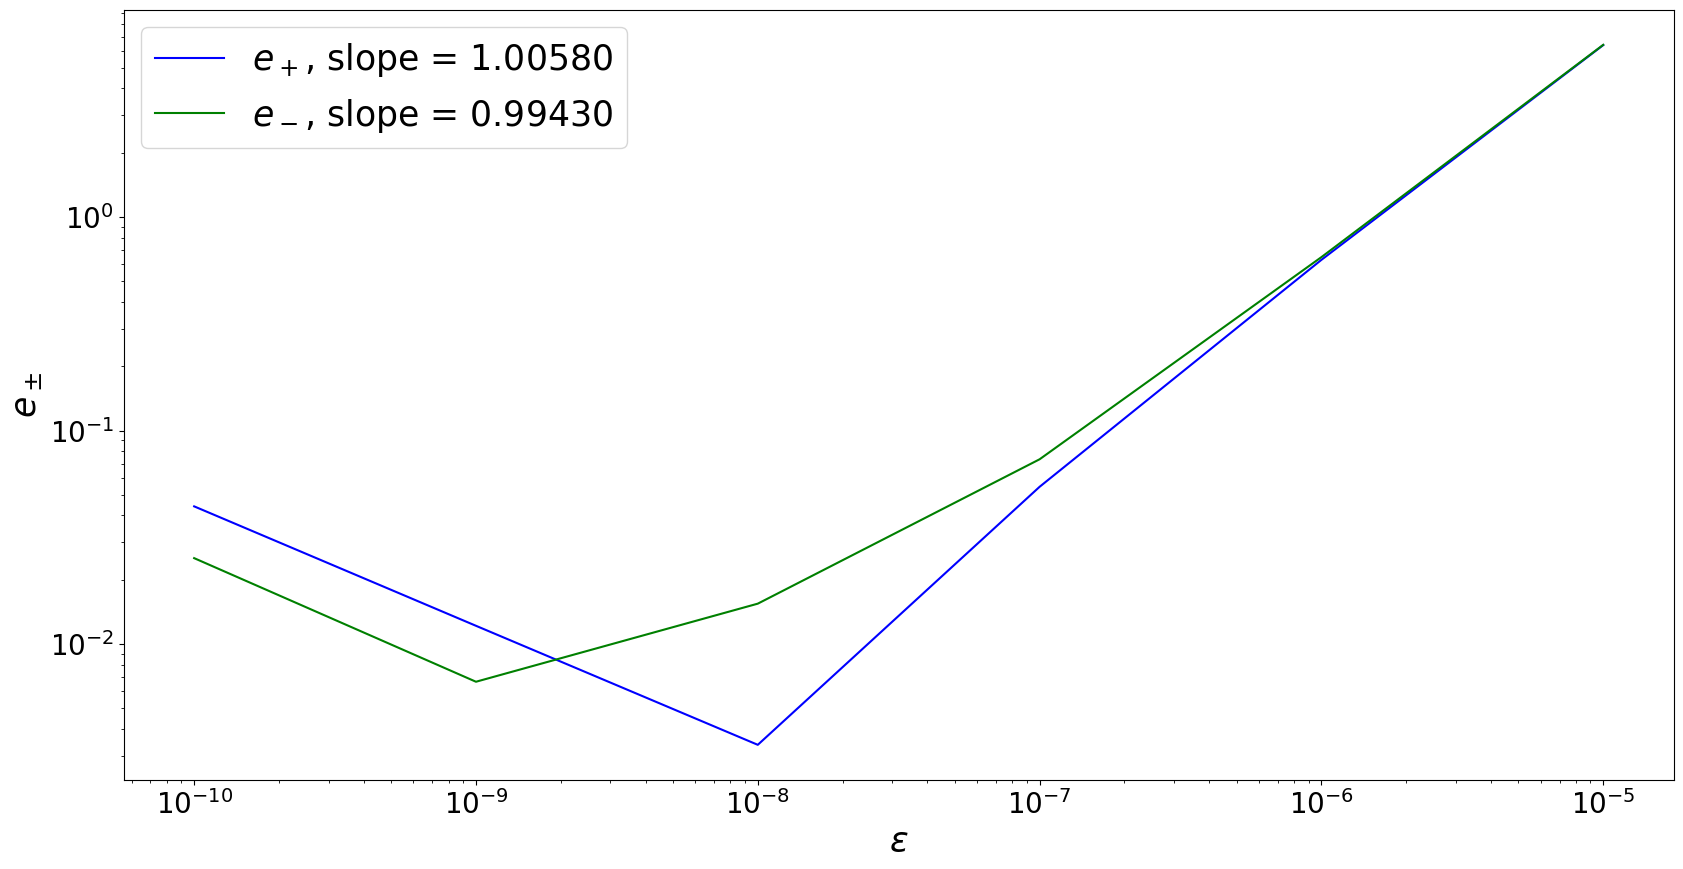

In [16]:
error_p = np.abs(1-(dj_p/dj))
error_m = np.abs(1-(dj_m/dj))

slope_p = (np.log(error_p[-1]) - np.log(error_p[-2]))/(np.log(eps_a[-1]) - np.log(eps_a[-2]))
slope_m = (np.log(error_m[-1]) - np.log(error_m[-2]))/(np.log(eps_a[-1]) - np.log(eps_a[-2]))

fontsize = 25

plt.figure(0, figsize=(20, 10))
plt.plot(eps_a, error_p,'b', label=r'$e_+$'+f', slope = {"{:.5f}".format(slope_p)}')
plt.plot(eps_a, error_m,'g', label=r'$e_-$'+f', slope = {"{:.5f}".format(slope_m)}')
plt.xlabel(r'$\epsilon$', fontsize=fontsize)
plt.ylabel(r'$e_\pm$', fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',prop={'size': fontsize})
plt.tick_params(axis='both',labelsize=fontsize-5)